In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/forest-cover-type-prediction/train.csv")

In [ ]:
# Make Copy of train_data data
copy_train_data = train_data
copy_train_data.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [ ]:
# Mean hillshade of the hillshade at 9AM, Noon, and 3PM (0-255)
copy_train_data['Hillshade_mean'] = (copy_train_data['Hillshade_9am'] +
                                     copy_train_data['Hillshade_Noon'] +
                                     copy_train_data['Hillshade_3pm'])/3

# 9AM, Noon, 3PM hillshade squared
copy_train_data['Hillshade_9am_sq'] = np.square(copy_train_data['Hillshade_9am'])
copy_train_data['Hillshade_Noon_sq'] = np.square(copy_train_data['Hillshade_Noon'])
copy_train_data['Hillshade_3pm_sq'] = np.square(copy_train_data['Hillshade_3pm'])

# interaction_9amnoon	Product of hillshades at 9AM and Noon
# interaction_noon3pm	Product of hillshades at Noon and 3PM
# interaction_9am3pm	Product of hillshades at 9AM and 3PM

copy_train_data['interaction_9amnoon'] = np.multiply(copy_train_data['Hillshade_9am'], copy_train_data['Hillshade_Noon'])
copy_train_data['interaction_noon3pm'] = np.multiply(copy_train_data['Hillshade_Noon'], copy_train_data['Hillshade_3pm'])
copy_train_data['interaction_9am3pm'] = np.multiply(copy_train_data['Hillshade_3pm'], copy_train_data['Hillshade_9am'])

copy_train_data.drop(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], axis=1, inplace=True)

In [ ]:
# Square root of the sum of the squared horizontal & vertical distances to water
sum_of_squared_distances = copy_train_data['Horizontal_Distance_To_Hydrology']**2 + copy_train_data['Vertical_Distance_To_Hydrology']**2
copy_train_data['Euclidean_Distance_To_Hydrology'] = np.sqrt(sum_of_squared_distances)

In [ ]:
# Logarithm of elevation
copy_train_data['log_elevation'] = np.log(copy_train_data['Elevation'])

# cosine_slope	The cosine of the slope, used to partially model the relationships between hillshade
copy_train_data['cosine_slope'] = np.cos(np.radians(copy_train_data['Slope']))

In [ ]:
X = copy_train_data.drop(['Id', 'Soil_Type7', 'Soil_Type15', 'Cover_Type'], axis=1)
y = copy_train_data['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr = LogisticRegression(random_state=42, class_weight = 'balanced', max_iter=200, penalty='l1', solver='liblinear')
rfc = RandomForestClassifier(random_state=42, bootstrap=True, class_weight = 'balanced', criterion='entropy', max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
ext = ExtraTreesClassifier(random_state=42, bootstrap=True, class_weight = 'balanced', criterion='entropy', max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
dtc = DecisionTreeClassifier(random_state=42, criterion='entropy', min_samples_leaf=1, min_samples_split=2)
gbc = GradientBoostingClassifier(random_state=42, criterion='friedman_mse', learning_rate=0.1, max_features=None, n_estimators=500)
hgbc = HistGradientBoostingClassifier(random_state=42, learning_rate=0.1, max_iter=500)

# **CASE-I**

In [ ]:
algo_1 = [('lr', lr),('ext', ext),('dtc', dtc), ('gbc', gbc), ('hgbc', hgbc)]
stack_model_1 = StackingClassifier(estimators = algo_1, final_estimator = rfc)
score_1 = cross_val_score(stack_model_1, X_train, y_train, cv = 5,scoring = 'accuracy')
print("Model accuracy:",score_1.mean())

Model accuracy: 0.8595994885225643


In [ ]:
algo_1 = [('lr', lr),('ext', ext),('dtc', dtc), ('gbc', gbc), ('hgbc', hgbc)]
stack_model_1 = StackingClassifier(estimators = algo_1, final_estimator = rfc)

stack_model_1.fit(X_train, y_train)

y_pred = stack_model_1.predict(X_test)
stackmodel1_accuracy = accuracy_score(y_test, y_pred)
stackmodel1_conf_matrix = confusion_matrix(y_test, y_pred)
stackmodel1_classification_report = classification_report(y_test, y_pred)

print('Stack Model-1 Test Accuracy: \n', stackmodel1_accuracy)
print('Stack Model-1 Test Confusion matrix: \n', stackmodel1_conf_matrix)
print('Stack Model-1 Test Classification report: \n', stackmodel1_classification_report)

Stack Model-1 Test Accuracy: 
 0.8584656084656085
Stack Model-1 Test Confusion matrix: 
 [[453 136   1   0  10   0  20]
 [ 95 495  22   0  33  11   2]
 [  0   3 559  18   2  63   0]
 [  0   0  16 639   0   6   0]
 [  0  33  16   0 599   2   0]
 [  0   9  89  12   2 538   0]
 [ 41   0   0   0   0   0 611]]
Stack Model-1 Test Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.73      0.75       620
           2       0.73      0.75      0.74       658
           3       0.80      0.87      0.83       645
           4       0.96      0.97      0.96       661
           5       0.93      0.92      0.92       650
           6       0.87      0.83      0.85       650
           7       0.97      0.94      0.95       652

    accuracy                           0.86      4536
   macro avg       0.86      0.86      0.86      4536
weighted avg       0.86      0.86      0.86      4536



# **CASE-II**

In [ ]:
algo_2 = [('ext', ext), ('gbc', gbc), ('hgbc', hgbc)]
stack_model_2 = StackingClassifier(estimators = algo_2, final_estimator = rfc)
score_2 = cross_val_score(stack_model_2, X_train, y_train, cv = 5,scoring = 'accuracy')
print("Model accuracy:",score_2.mean())

Model accuracy: 0.8561037527692378


In [ ]:
algo_2 = [('ext', ext), ('gbc', gbc), ('hgbc', hgbc)]
stack_model_2 = StackingClassifier(estimators = algo_2, final_estimator = rfc)

stack_model_2.fit(X_train, y_train)

y_pred = stack_model_2.predict(X_test)
stackmodel2_accuracy = accuracy_score(y_test, y_pred)
stackmodel2_conf_matrix = confusion_matrix(y_test, y_pred)
stackmodel2_classification_report = classification_report(y_test, y_pred)

print('Stack Model-2 Test Accuracy: \n', stackmodel2_accuracy)
print('Stack Model-2 Test Confusion matrix: \n', stackmodel2_conf_matrix)
print('Stack Model-2 Test Classification report: \n', stackmodel2_classification_report)

Stack Model-2 Test Accuracy: 
 0.8509700176366843
Stack Model-2 Test Confusion matrix: 
 [[452 137   1   0  10   2  18]
 [ 93 497  21   0  33  12   2]
 [  0   1 542  19   3  80   0]
 [  0   0  15 636   0  10   0]
 [  0  38  16   0 594   2   0]
 [  0   9  93  14   4 530   0]
 [ 43   0   0   0   0   0 609]]
Stack Model-2 Test Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.73      0.75       620
           2       0.73      0.76      0.74       658
           3       0.79      0.84      0.81       645
           4       0.95      0.96      0.96       661
           5       0.92      0.91      0.92       650
           6       0.83      0.82      0.82       650
           7       0.97      0.93      0.95       652

    accuracy                           0.85      4536
   macro avg       0.85      0.85      0.85      4536
weighted avg       0.85      0.85      0.85      4536



# **CASE-III**

In [ ]:
algo_3 = [('ext', ext), ('gbc', gbc), ('dtc', dtc)]
stack_model_3 = StackingClassifier(estimators = algo_3, final_estimator = rfc)
score_3 = cross_val_score(stack_model_3, X_train, y_train, cv = 5,scoring = 'accuracy')
print("Model accuracy:",score_3.mean())

Model accuracy: 0.8407025492614026


In [ ]:
algo_3 = [('ext', ext), ('gbc', gbc), ('dtc', dtc)]
stack_model_3 = StackingClassifier(estimators = algo_3, final_estimator = rfc)

stack_model_3.fit(X_train, y_train)

y_pred = stack_model_3.predict(X_test)
stackmodel3_accuracy = accuracy_score(y_test, y_pred)
stackmodel3_conf_matrix = confusion_matrix(y_test, y_pred)
stackmodel3_classification_report = classification_report(y_test, y_pred)

print('Stack Model-3 Test Accuracy: \n', stackmodel3_accuracy)
print('Stack Model-3 Test Confusion matrix: \n', stackmodel3_conf_matrix)
print('Stack Model-3 Test Classification report: \n', stackmodel3_classification_report)

Stack Model-3 Test Accuracy: 
 0.8549382716049383
Stack Model-3 Test Confusion matrix: 
 [[445 133   1   0  13   2  26]
 [101 475  21   0  47  11   3]
 [  0   5 522  29   2  87   0]
 [  0   0  11 644   0   6   0]
 [  1  23  14   0 609   3   0]
 [  0  11  65  13   1 560   0]
 [ 29   0   0   0   0   0 623]]
Stack Model-3 Test Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.72      0.74       620
           2       0.73      0.72      0.73       658
           3       0.82      0.81      0.82       645
           4       0.94      0.97      0.96       661
           5       0.91      0.94      0.92       650
           6       0.84      0.86      0.85       650
           7       0.96      0.96      0.96       652

    accuracy                           0.85      4536
   macro avg       0.85      0.85      0.85      4536
weighted avg       0.85      0.85      0.85      4536



# **CASE-IV**

In [ ]:
algo_4 = [('lr', lr),('rfc', rfc),('dtc', dtc), ('gbc', gbc)]
stack_model_4 = StackingClassifier(estimators = algo_4, final_estimator = ext)
score_4 = cross_val_score(stack_model_4, X_train, y_train, cv = 5,scoring = 'accuracy')
print("Model accuracy:",score_4.mean())

Model accuracy: 0.8419318184862303


In [ ]:
algo_4 = [('lr', lr),('rfc', rfc),('dtc', dtc), ('gbc', gbc)]
stack_model_4 = StackingClassifier(estimators = algo_4, final_estimator = ext)

stack_model_4.fit(X_train, y_train)

y_pred = stack_model_4.predict(X_test)
stackmodel4_accuracy = accuracy_score(y_test, y_pred)
stackmodel4_conf_matrix = confusion_matrix(y_test, y_pred)
stackmodel4_classification_report = classification_report(y_test, y_pred)

print('Stack Model-4 Test Accuracy: \n', stackmodel4_accuracy)
print('Stack Model-4 Test Confusion matrix: \n', stackmodel4_conf_matrix)
print('Stack Model-4 Test Classification report: \n', stackmodel4_classification_report)

Stack Model-4 Test Accuracy: 
 0.8511904761904762
Stack Model-4 Test Confusion matrix: 
 [[463 119   1   0  10   1  26]
 [106 462  20   0  51  15   4]
 [  0   4 513  27   2  99   0]
 [  0   0  12 641   0   8   0]
 [  1  24  15   0 608   2   0]
 [  0  12  65  15   3 555   0]
 [ 33   0   0   0   0   0 619]]
Stack Model-4 Test Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.75      0.76       620
           2       0.74      0.70      0.72       658
           3       0.82      0.80      0.81       645
           4       0.94      0.97      0.95       661
           5       0.90      0.94      0.92       650
           6       0.82      0.85      0.83       650
           7       0.95      0.95      0.95       652

    accuracy                           0.85      4536
   macro avg       0.85      0.85      0.85      4536
weighted avg       0.85      0.85      0.85      4536



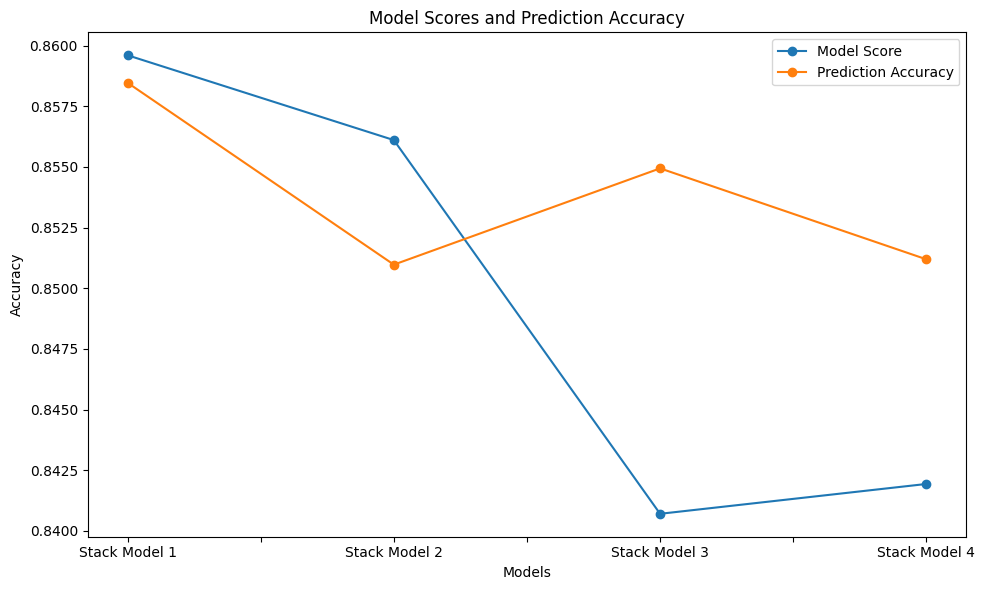

In [ ]:
modelcases = ['Stack Model 1', 'Stack Model 2', 'Stack Model 3', 'Stack Model 4']
modelscore = [score_1, score_2, score_3, score_4]
predictionaccuracy = [stackmodel1_accuracy, stackmodel2_accuracy, stackmodel3_accuracy, stackmodel4_accuracy]

accuracy_data = pd.DataFrame({'Model Cases': modelcases, 'Model Score': modelscore, 'Prediction Accuracy': predictionaccuracy})
accuracy_data.set_index('Model Cases', inplace=True)

ax = accuracy_data.plot(kind='line', rot=0, marker='o', figsize=(10, 6))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Scores and Prediction Accuracy')
plt.legend()
plt.tight_layout()
plt.show()